In [103]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

from matplotlib import pyplot as plt
import torch

# MNIST Dataset

## Train

AnomalyMNIST Dataset (Number of samples: 2600, Number of known anomalies: 400, Number of unknown anomalies: 200)


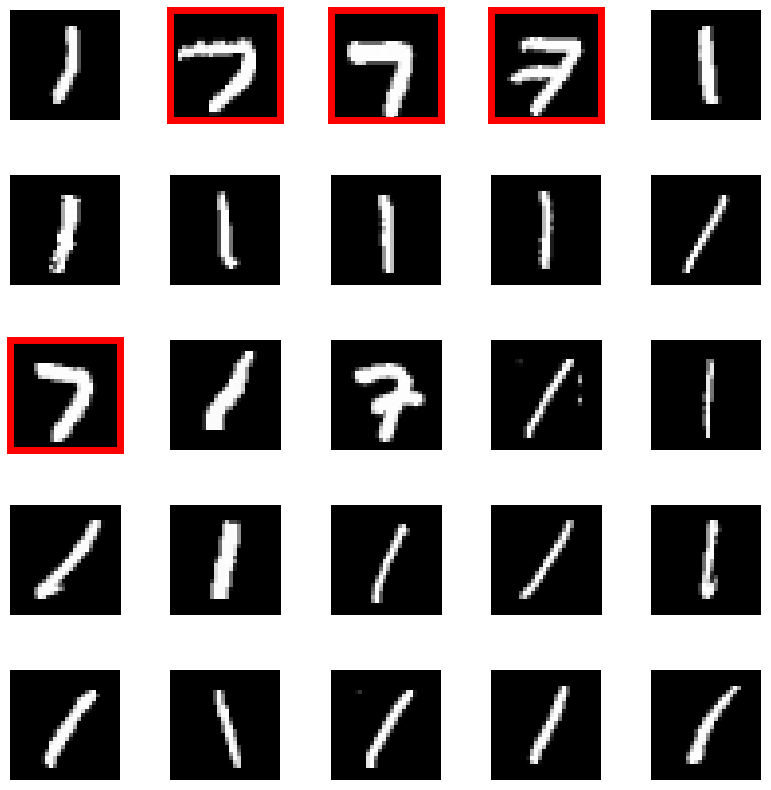

In [104]:
from dataset import AnomalyMNIST
from torchvision.transforms import Normalize,ToTensor, Compose


seed = 42
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# dataset = AnomalyMNIST('data/', download=True, transform=transform, n_known_anomalies=512, pollution=0.25, seed=seed)
dataset = AnomalyMNIST('data/', download=True, transform=transform, n_normal_samples=2000, known_anomalies=0.2, pollution=0.1, seed=seed)
print(dataset)

dataset.montage(5, 5, seed)
plt.show()

In [105]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

## Test

In [106]:
# TODO: Include the test set configuration in the AnoamlyMNIST class
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

test_dataset_full = MNIST('data/', train = False, download = True, transform = transform)
normal_idx = torch.where((test_dataset_full.targets == 1))[0]
anomaly_idx = torch.where((test_dataset_full.targets == 7))[0]
idx = torch.cat([normal_idx[:256], anomaly_idx[:256]]) # 512 samples!

test_dataset_full.targets = torch.ones_like(test_dataset_full.targets) * -1
test_dataset_full.targets[normal_idx] = 0
test_dataset_full.targets[anomaly_idx] = 1

x_test_set = Subset(test_dataset_full, idx)
test_loader =  DataLoader(x_test_set, 512, shuffle=False)

Anomaly


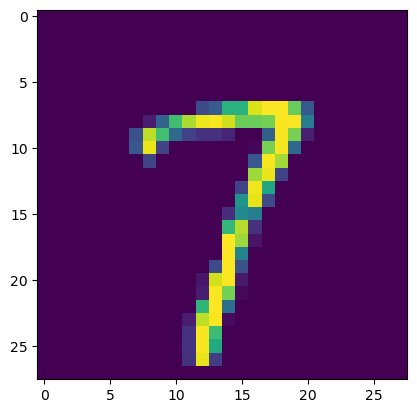

In [107]:
# TO REMOVE! Just testing!
import random
random.seed(64)
random_idx = random.randint(0, 511)
x, y = x_test_set[random_idx]
plt.imshow(x[0])
print('Anomaly' if y == 1 else 'Normal')

# Model

In [108]:
from ADeLEn.model import ADeLEn
from torch.nn.functional import mse_loss
from VAE.loss import SGVBL

# model = ADeLEn((28, 28), [1, 12, 32], [1024, 512, 128, 2], skip_connection=False)
model = ADeLEn((28, 28), [1, 12, 32], [1024, 256, 32], bottleneck=2, skip_connection=False)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(dataset), mle=mse_loss)

# Training

In [109]:
def train(model, dataset, batch_size, n_epochs, lr=1e-3, kl_weight=1):
    from tqdm import tqdm
    from torch.utils.data import DataLoader
    from torch.optim import Adam
    
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )
    
    opt = Adam(model.parameters(), lr=lr)

    for _ in epoch_iterator:
        epoch_loss = 0.
        for x, y in train_loader:
            x = x.to(device) 
            opt.zero_grad()
            x_hat = torch.tanh(model(x))
            loss = sgvbl(x, x_hat, y, kl_weight)
            epoch_loss += loss.detach().item()

            loss.backward()
            opt.step()

        epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

    return model.eval().cpu()


In [110]:
model = train(model, dataset, 128, 100, 1e-3, 1)

100%|██████████| 100/100 [00:34<00:00,  2.91epoch/s, tls=615.740]


# Result

In [111]:
import numpy as np

def plot_latent(model, data, num_batches=100):
    model.eval()
    fig = plt.figure(figsize=(5,5))
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            # x = x.to(device)
            z = model.bottleneck(model.encode_path(x))
            z = z.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            anomalies = np.where(y == 1)
            normal = np.where(y == 0)
            if i == 0:
                plt.scatter(z[normal, 0], z[normal, 1], c='r', alpha=.7, label='normal')
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b', alpha=.7, label='anomalies')
            else:
                plt.scatter(z[normal, 0], z[normal, 1], c='r',alpha=.7)
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b',alpha=.7)
           
            if i > num_batches:
                plt.legend()
                return
    plt.legend()
    return fig

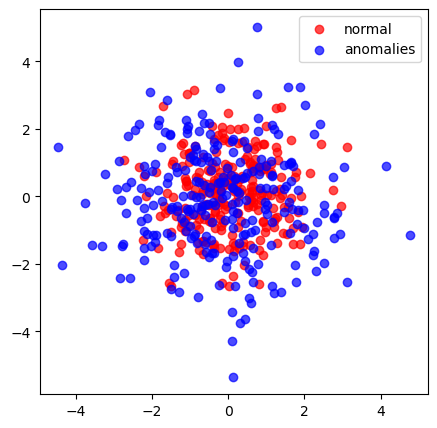

In [112]:
model.eval()
# model.train()
fig = plot_latent(model, test_loader, num_batches=25)
plt.savefig('figures/latent_space_test.png', dpi=300, bbox_inches='tight')

## Sampling normal and anomaly sample

torch.Size([1, 1, 28, 28])


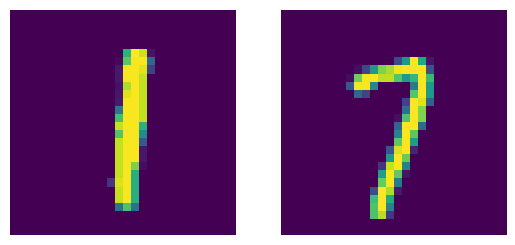

In [113]:
x, y = next(iter(test_loader))
x_0 = x[torch.argwhere(y==0).squeeze()[150]].unsqueeze(0)
x_1 = x[torch.argwhere(y==1).squeeze()[152]].unsqueeze(0)

print(x_0.shape)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x_1[0,0])
plt.axis('off')
plt.savefig('figures/anomalies.png', bbox_inches='tight')

model.eval()
z_0, z_1 = [], []
for i in range(100):
    z_0.append(model.bottleneck(model.encode_path(x_0)).detach().cpu())
    z_1.append(model.bottleneck(model.encode_path(x_1)).detach().cpu())

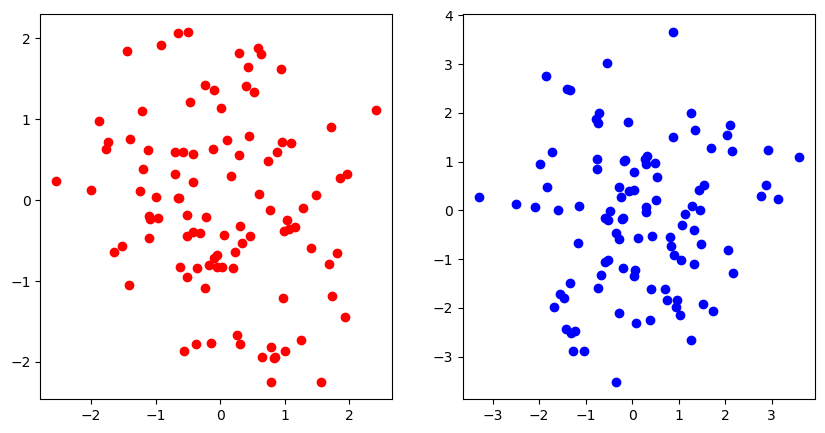

In [114]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')
plt.savefig('figures/anomalies_latent_sample.png', bbox_inches='tight')

In [115]:
x = torch.cat([x_0, x_1])
print(x.shape)

model.eval()
with torch.no_grad():
    x_hat = model(x)

model.bottleneck.sigma.detach(), model.bottleneck.mu.detach()

torch.Size([2, 1, 28, 28])


(tensor([[0.9779, 1.0509],
         [1.5413, 1.3801]]),
 tensor([[ 0.0004, -0.0014],
         [-0.0127, -0.0004]]))

In [116]:
x, y = next(iter(test_loader))
x_0 = x[torch.argwhere(y==0).squeeze()[:200]]
x_1 = x[torch.argwhere(y==1).squeeze()[:200]]

x = torch.cat([x_0, x_1])
model.eval()
with torch.no_grad():
    x_hat = model(x)

model.bottleneck.sigma[:200].detach().mean(), model.bottleneck.sigma[200:400].detach().mean()

(tensor(1.0306), tensor(1.5731))

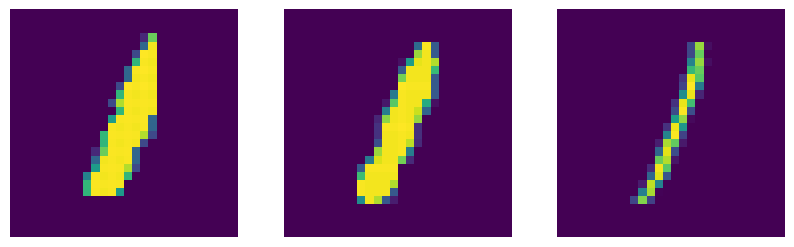

In [117]:
# Get the idx of the highest 3 sigma
idx = torch.argsort(model.bottleneck.sigma[:200].mean(axis=1), descending=True)
model.bottleneck.sigma[idx[:3]]

to_show = x[idx[:3]]
fig = plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(to_show[i,0])
    plt.axis('off')

## Reconstruction

In [118]:
import numpy as np
def plot_reconstructed(model, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))

    fig = plt.figure(figsize=(5, 5))

    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = torch.tanh(model.decode_path(z)) # ADeLEn
            x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
    plt.xlabel('$\mathcal{N}(0, \sigma_1)$', fontsize='x-large')
    plt.ylabel('$\mathcal{N}(0, \sigma_2)$', fontsize='x-large')
    plt.tick_params(axis='both', which='major', labelsize='large')
    plt.imshow(img, extent=[*r0, *r1], cmap='viridis')

    return fig

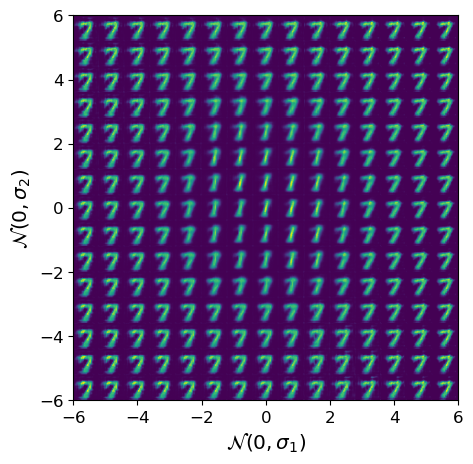

In [119]:
model.eval()
fig = plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=15)
plt.savefig('figures/reconstructed.pdf', bbox_inches='tight')
plt.show(fig)

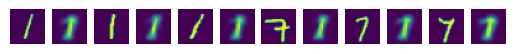

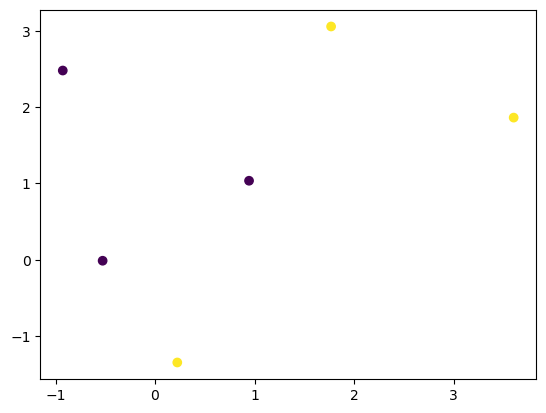

In [120]:
test_idx = torch.linspace(0, 511, 6, dtype=int)
x, y = next(iter(test_loader))
x_hat = torch.tanh(model(x).detach().cpu())
z = model.bottleneck(model.encode_path(x)).detach().cpu()

for i, idx in enumerate(test_idx):
    plt.subplot(1, 2*len(test_idx), 2*(i+1)-1)
    plt.imshow(x[idx, 0])
    plt.axis('off')

    plt.subplot(1, 2*len(test_idx), 2*(i+1))
    plt.imshow(x_hat[idx,0])
    plt.axis('off')

plt.show()

plt.scatter(z[test_idx, 0], z[test_idx, 1], c=y[test_idx] )
plt.show()

# Test

In [121]:
from torchvision.datasets import MNIST

test_dataset = MNIST('data/', train = False, download = True, transform = transform)
# extract the 1's and 7's
normal_idx = torch.where((test_dataset.targets == 1))[0]
anomaly_idx = torch.where((test_dataset.targets == 7))[0]

print('Normal: {} samples; Anomalies: {} samples'.format(len(normal_idx), len(anomaly_idx)))

test_dataset = Subset(test_dataset, torch.cat([normal_idx, anomaly_idx]))
test_loader = DataLoader(test_dataset, 3000, shuffle=False)

# for x, y in test

Normal: 1135 samples; Anomalies: 1028 samples


In [122]:
x, y = next(iter(test_loader))
y[y==1] = 0
y[y==7] = 1

_ = model(x)

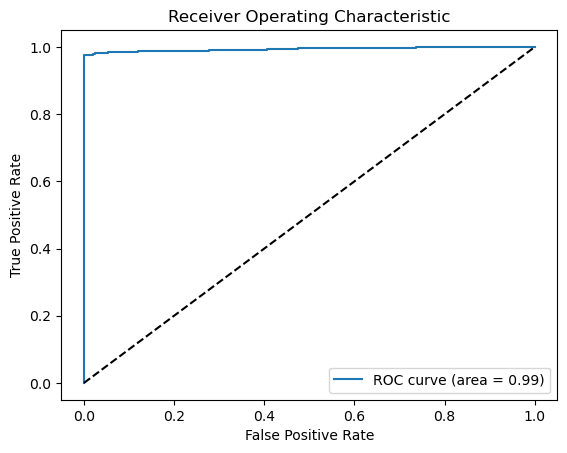

In [123]:
y_score = model.score_samples(x)
# model.bottleneck.sigma.sum(axis=1).detach().cpu().numpy()

from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [124]:
import torch
from sklearn.metrics import roc_curve, auc

x, y = zip(*[(_x, _y) for _x, _y in test_dataset])
x = torch.stack(x)
y = torch.tensor(y)
y[y==1] = 0
y[y==7] = 1

y_score = model.score_samples(x, normalize=True)
# sigma = experiment.model.bottleneck.sigma
# normalize = np.log(2*torch.pi*torch.e)
# y_score = 0.5 * (len(sigma) * normalize + torch.log(torch.sum(sigma, dim=1)).detach().numpy())
# # y_score = normalize + torch.log(torch.prod(sigma, dim=1)).detach().numpy()
        
fpr, tpr, thresholds = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

roc_auc

0.9937066113577538

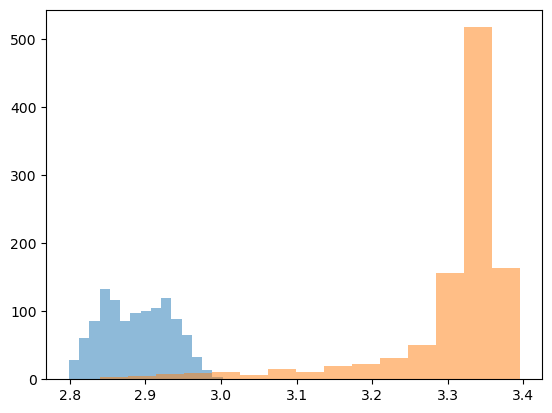

In [125]:
from matplotlib import pyplot as plt
plt.hist(y_score[y==0], bins=15, alpha=0.5, label='Normal')
plt.hist(y_score[y==1], bins=15, alpha=0.5, label='Anomaly')
plt.show()

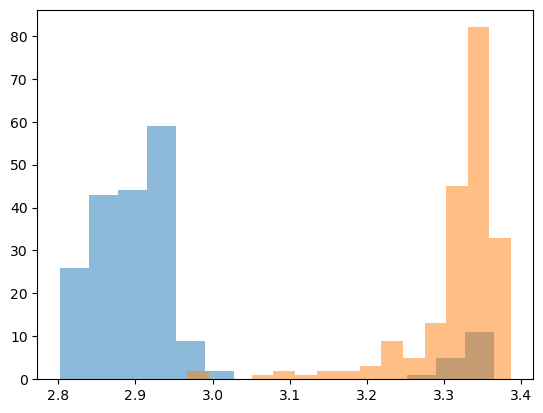

In [126]:
x, y = zip(*[(_x, _y) for _x, _y in dataset])

x = torch.stack(x)
y = torch.tensor(y)

x0 = x[y==0]
x0_idx = torch.randperm(len(x0))[:200]
x0 = x0[x0_idx]
x1 = x[y==1]
x1_idx = torch.randperm(len(x1))[:200]
x1 = x1[x1_idx]

x = torch.cat([x0, x1])
y = torch.cat([torch.zeros(200), torch.ones(200)])

y_score = model.score_samples(x, normalize=True)
fpr, tpr, thresholds = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

from matplotlib import pyplot as plt
plt.hist(y_score[y==0], bins=15, alpha=0.5, label='Normal')
plt.hist(y_score[y==1], bins=15, alpha=0.5, label='Anomaly')
plt.show()

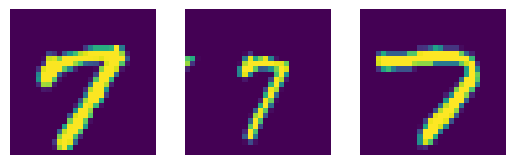

In [127]:
_y0_score = y_score[:200]
_y1_score = y_score[200:]

# get the idx of the highest 3 sigma
idx = torch.argsort(torch.tensor(_y0_score), descending=True)

plt.subplot(1, 3, 1)
plt.imshow(x0[idx[0]][0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x0[idx[1]][0])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(x0[idx[2]][0])
plt.axis('off')

plt.show()

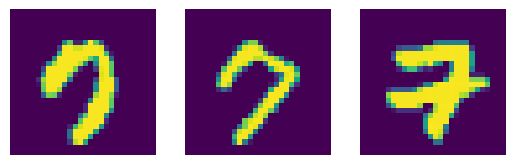

In [129]:
_y1_score = y_score[200:]

# get the idx of the highest 3 _y1_score
idx = torch.argsort(torch.tensor(_y0_score), descending=False)

plt.subplot(1, 3, 1)
plt.imshow(x1[idx[0]][0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x1[idx[1]][0])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(x1[idx[2]][0])
plt.axis('off')

plt.show()

In [92]:
idx

tensor(511)

In [90]:
# Calcular la diferencia entre TPR y FPR para cada umbral
differences = tpr - fpr

# Encontrar el índice del umbral que maximiza la diferencia
optimal_threshold_index = np.argmax(differences)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print("Optimal threshold:", optimal_threshold)

Optimal threshold: 2.9535193


In [105]:
normalize = np.log(2*torch.pi*torch.e)

sigma = model.bottleneck.sigma[:2]

y_score = 0.5 * (len(sigma) * normalize + torch.log(sigma).sum(dim=1).detach().numpy())
y_score

array([2.8723595, 2.8773098], dtype=float32)